In [1]:
import numpy as np
import matplotlib.pylab as plt

#from scripts.simulations.engines.lattice_translocators import LEFTranslocator, LEFTranslocatorDynamicBoundary
#from scripts.simulations.utils.funcs import *
from dynamic_extrusion_boundaries.funcs import *
import cooltools
import cooltools.lib.plotting
%matplotlib inline

/home1/rahmanin/.conda/envs/openwpoly/lib/python3.7/site-packages/cooltools/lib/numutils.py:11: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from ._numutils import (
/home1/rahmanin/.conda/envs/openwpoly/lib/python3.7/site-packages/cooltools/api/expected.py:14: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from cooler.tools import partition


### params

In [3]:
paramdict_CTCF = {
    'CTCF_facestall': [1, 1],
    'CTCF_backstall': [0., 0.],
    'CTCF_lifetime': [100., 1.],
    'CTCF_offtime': [0.1, 1],
    'LEF_lifetime': [150, 150],
    'LEF_stalled_lifetime': [150, 150],
    'LEF_birth': [0.1, 0.1],
    'LEF_pause': [0, 0],
    'LEF_separation': 100,
    'sites_per_monomer': 10,
    'monomers_per_replica': 10,
    'number_of_replica': 10,
    'steps': 200,
    'velocity_multiplier': 1
}

In [4]:
monomers_per_replica = paramdict_CTCF['monomers_per_replica'] 
sites_per_monomer = paramdict_CTCF['sites_per_monomer']

sites_per_replica = monomers_per_replica*sites_per_monomer
monomer_types = np.zeros(monomers_per_replica, dtype=int)
site_types = np.repeat(monomer_types, sites_per_monomer)

100


In [5]:
# Let's make some strong and weak CTCF regions
typedict = {'strong_CTCF':1, 'weak_CTCF':0}

site_types[sites_per_replica//2:] = typedict['strong_CTCF']
site_types[:sites_per_replica//2] = typedict['weak_CTCF']

In [6]:
# LEF/CTCF properties in type A monomers may be obtained from the paramdict as follows
LEF_lifetime = paramdict_CTCF['LEF_lifetime']
CTCF_facestall = paramdict_CTCF['CTCF_facestall']
CTCF_offtime = paramdict_CTCF['CTCF_offtime']

print(CTCF_offtime[typedict['strong_CTCF']], CTCF_offtime[typedict['weak_CTCF']])

1 0.1


In [7]:
# Create some CTCF boundary sites

CTCF_left_positions = np.array([15,30])
CTCF_right_positions = np.array([70, 85])

In [8]:
def map_from_lefs(dset, sites_per_replica):
    
    ll = np.mod(dset.reshape((-1, 2)), sites_per_replica)
    ll = ll[ll[:,1] > ll[:,0]]
    
    lmap = np.histogram2d(ll[:,0], ll[:,1], np.arange(sites_per_replica))[0]
    
    return (lmap + lmap.T)

### dynamic barriers

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10


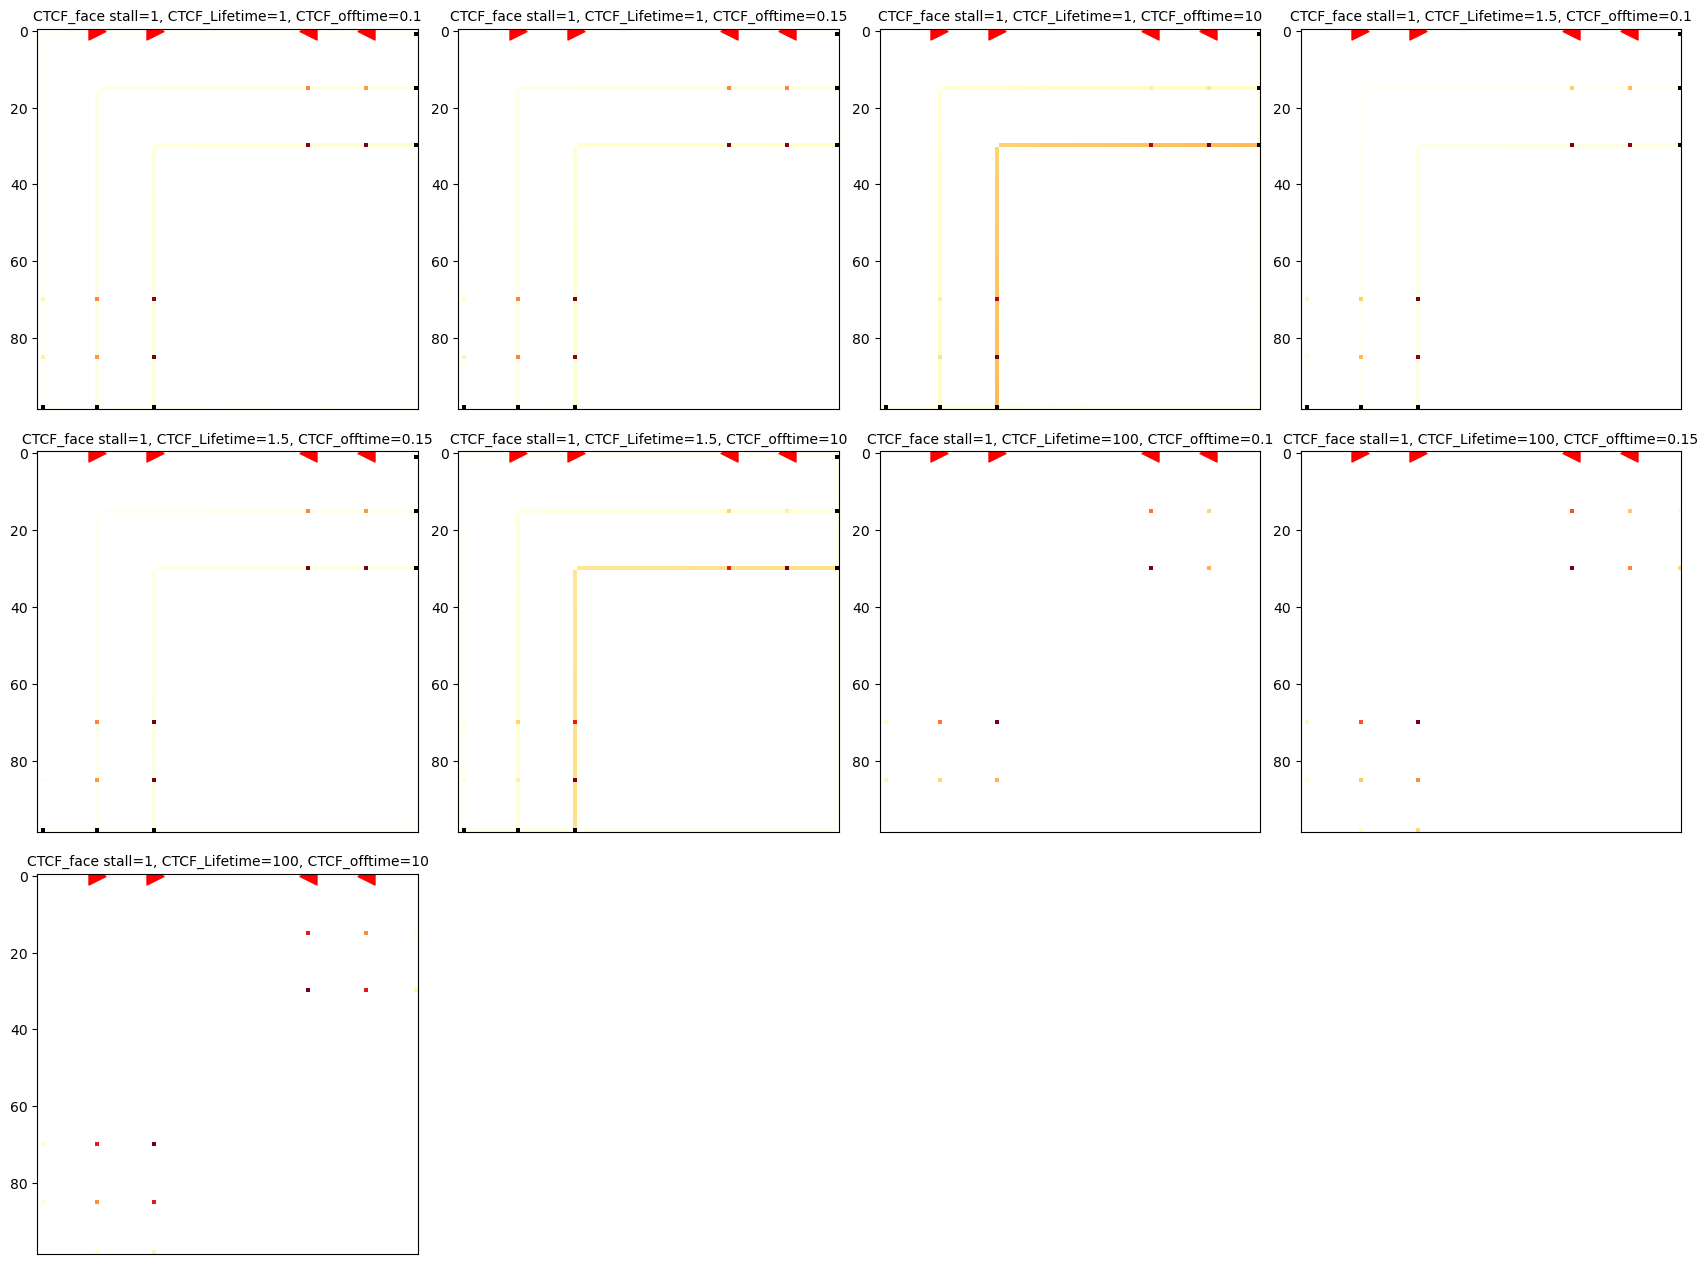

In [9]:


ctcf_life_range = [1, 1.5,  100]
ctcf_oftime_range = [0.1, 0.15,  10]
c=1
plt.figure(figsize=(17,17))
for ctcf_life in ctcf_life_range:
    for ctcf_oftime in ctcf_oftime_range:


        paramdict_CTCF['CTCF_lifetime']=[100, ctcf_life]
        paramdict_CTCF['CTCF_offtime']=[0.1, ctcf_oftime]
        
        translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                         site_types,
                                         CTCF_left_positions,
                                         CTCF_right_positions, 
                                         **paramdict_CTCF)
        
        trajectory_length = 175000
        hist = []
        plt.subplot(4,4,c)
        c +=1
        
        for _ in range(trajectory_length):
            translocator.step()
            hist.append(translocator.LEFs.copy())
        
        
        kymograph = map_from_lefs(np.asarray(hist), sites_per_replica)
        
        #print(kymograph)
        mrc  = kymograph.astype(float)
        merc = mrc/np.median(np.diag(mrc,2))
        mat = np.log10(mrc)
        #print(np.shape(mrc))
        #print(mrc)
        plt.matshow(mrc, vmax=np.max(mrc[10:90,10:90])/0.91,cmap='fall',fignum=False) 
        plt.scatter(CTCF_left_positions, [0,0], marker='>', color='red', s =150)
        plt.scatter(CTCF_right_positions, [0,0], marker='<', color='red', s =150)
                    
        plt.title('CTCF_face stall=%s, CTCF_Lifetime=%s, CTCF_offtime=%s' % (paramdict_CTCF['CTCF_facestall'][1],paramdict_CTCF['CTCF_lifetime'][1],
                                                          paramdict_CTCF['CTCF_offtime'][1]),
                  fontsize=10)
        
        plt.xticks([])
        plt.yticks(fontsize=10)
                
plt.tight_layout()
plt.show()                       
        

### three sequential barriers

150
1 0.1
700000


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[ 87  89]
 [ 86  90]
 [ 85  91]
 ...
 [  1 148]
 [  1 148]
 [  1 148]]


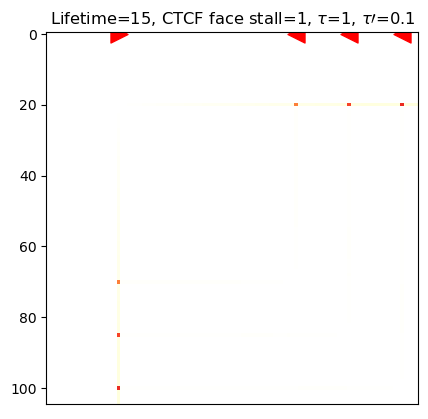

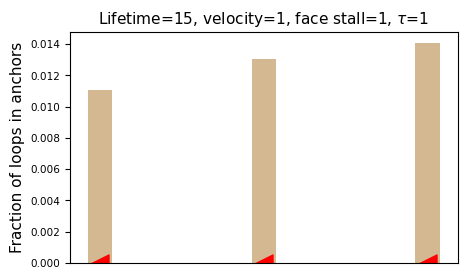

700000


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[69 72]
 [68 73]
 [67 74]
 ...
 [ 1 64]
 [ 1 65]
 [ 1 66]]


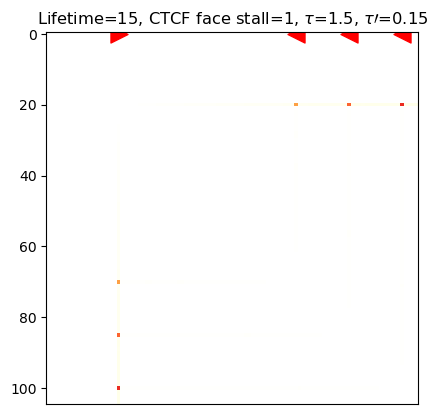

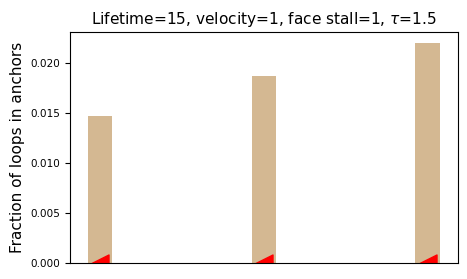

700000


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[112 115]
 [111 116]
 [110 117]
 ...
 [ 30  95]
 [ 30  95]
 [ 30  95]]


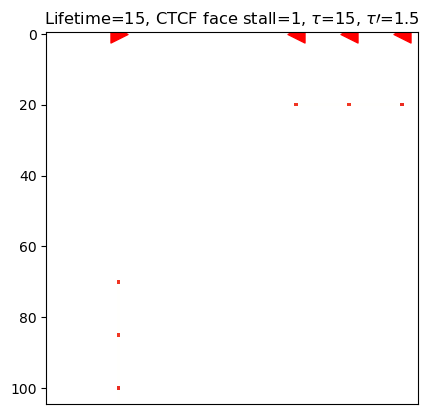

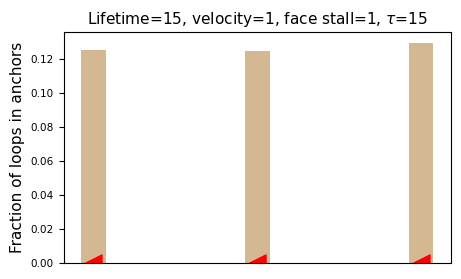

700000


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[67 70]
 [66 71]
 [65 72]
 ...
 [30 80]
 [30 80]
 [30 80]]


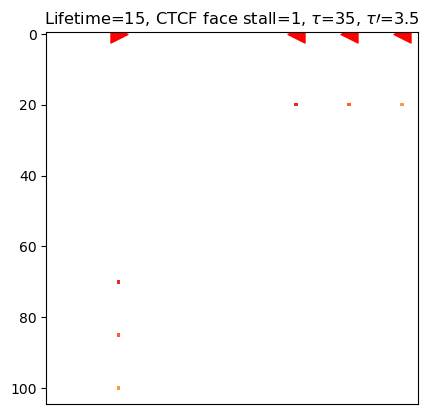

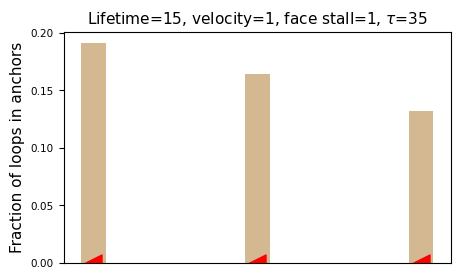

700000


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[109 110]
 [108 110]
 [107 110]
 ...
 [ 30  95]
 [ 30  95]
 [ 30  95]]


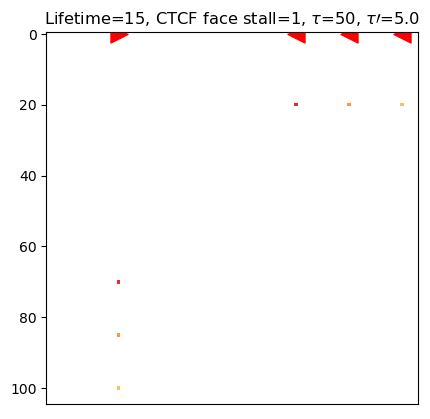

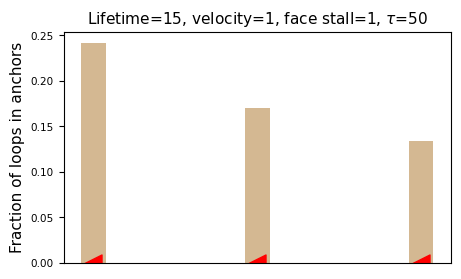

700000


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[ 73  76]
 [ 72  77]
 [ 71  78]
 ...
 [ 30 148]
 [ 30 148]
 [ 30 148]]


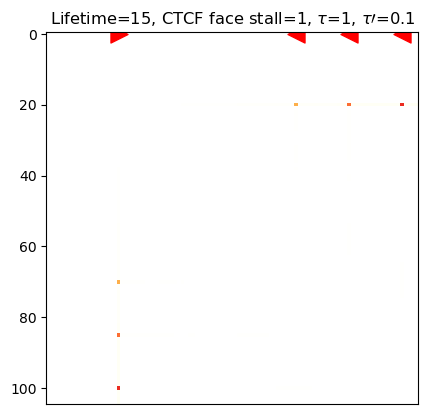

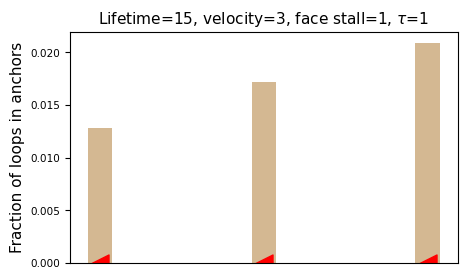

700000


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[ 34  36]
 [ 33  37]
 [ 32  38]
 ...
 [ 30 148]
 [ 30 148]
 [ 30 148]]


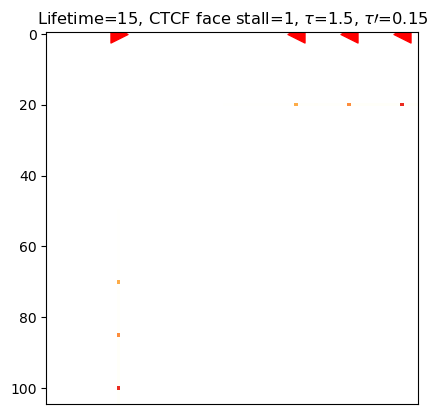

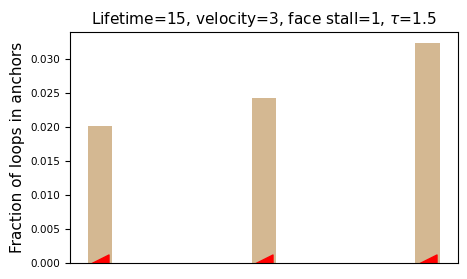

700000


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[37 39]
 [36 40]
 [35 41]
 ...
 [ 1 80]
 [ 1 80]
 [ 1 80]]


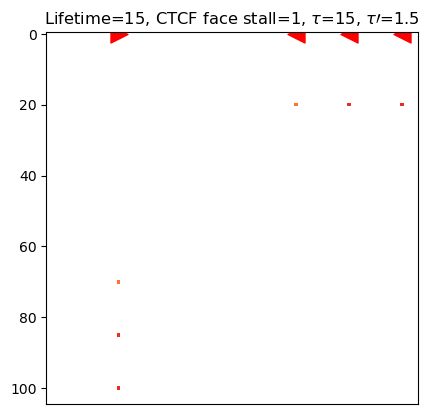

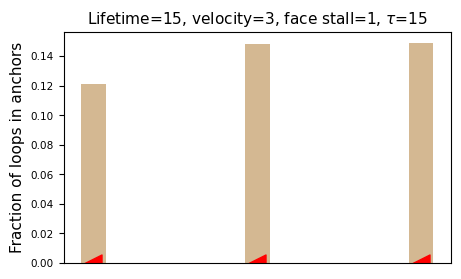

700000


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[ 8 11]
 [ 7 12]
 [ 6 13]
 ...
 [30 95]
 [30 95]
 [30 95]]


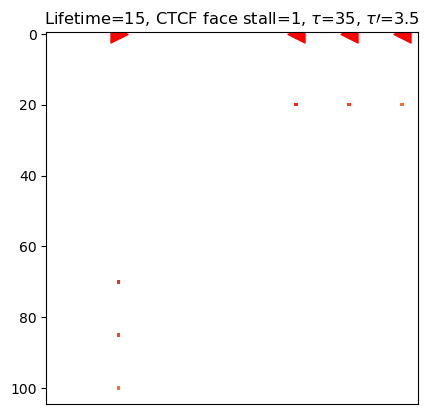

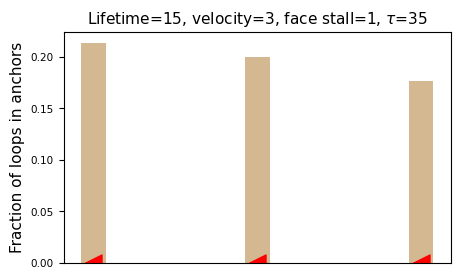

700000


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[ 72  74]
 [ 71  75]
 [ 70  76]
 ...
 [ 30 110]
 [ 30 110]
 [ 30 110]]


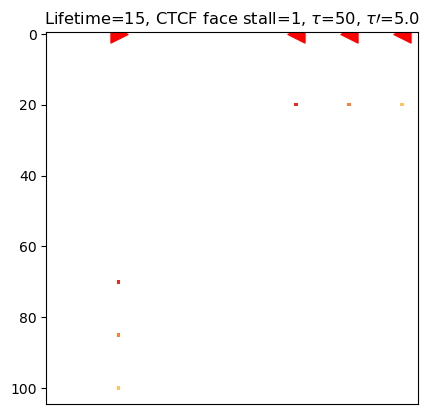

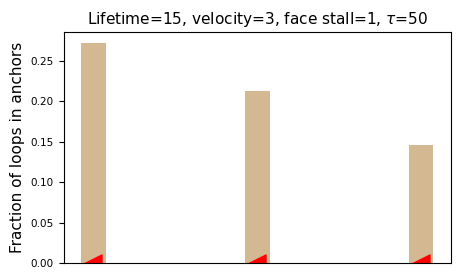

700000


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[106 109]
 [105 110]
 [104 110]
 ...
 [  1 148]
 [  1 148]
 [  1 148]]


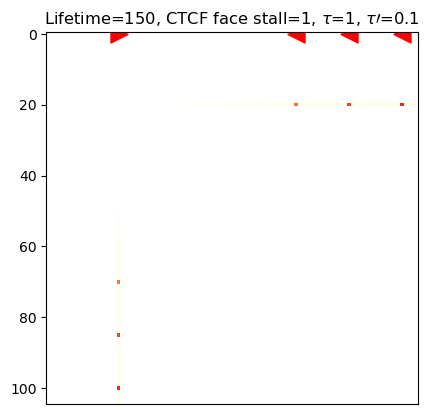

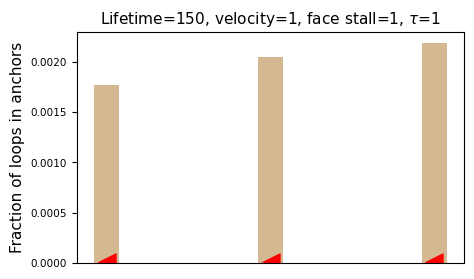

700000


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[77 80]
 [76 80]
 [75 80]
 ...
 [62 92]
 [61 93]
 [60 94]]


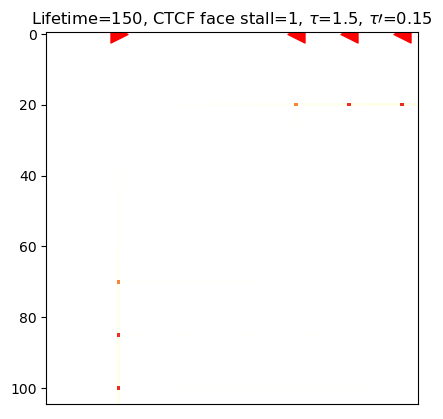

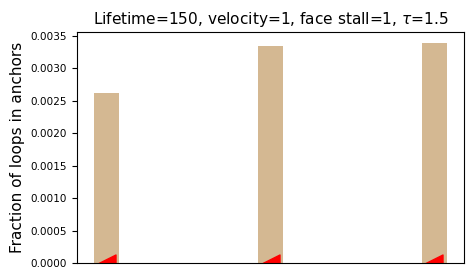

700000


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[121 124]
 [120 125]
 [119 126]
 ...
 [  1 148]
 [  1 148]
 [  1 148]]


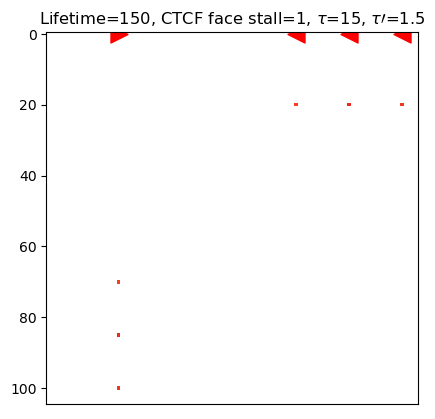

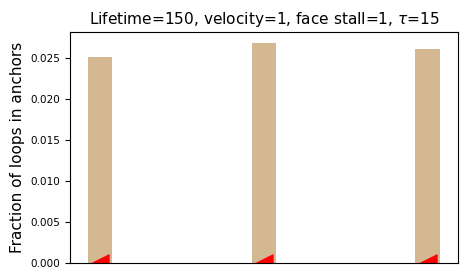

700000


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[60 62]
 [59 63]
 [58 64]
 ...
 [ 1 80]
 [ 1 80]
 [ 1 80]]


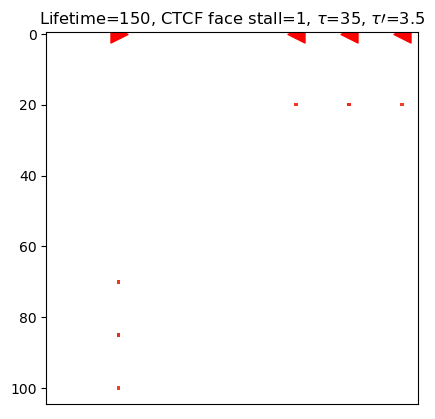

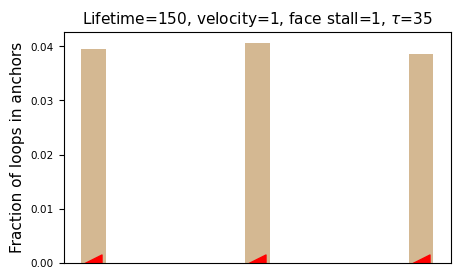

700000


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[ 88  91]
 [ 87  92]
 [ 86  93]
 ...
 [ 30 141]
 [ 30 142]
 [ 30 143]]


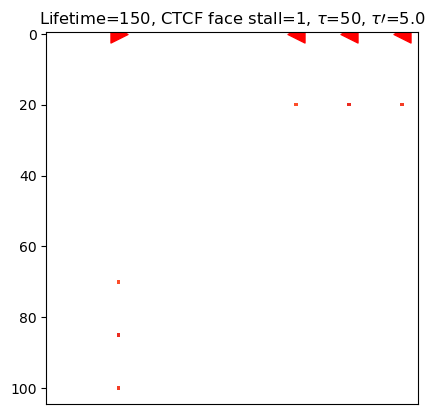

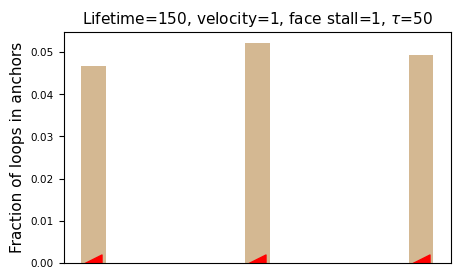

700000


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[ 54  56]
 [ 53  57]
 [ 52  58]
 ...
 [  1 148]
 [  1 148]
 [  1 148]]


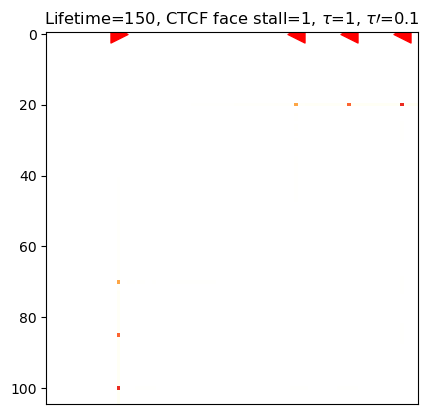

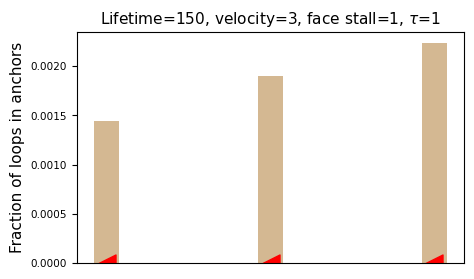

700000


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[ 51  54]
 [ 50  55]
 [ 49  56]
 ...
 [  1 148]
 [  1 148]
 [  1 148]]


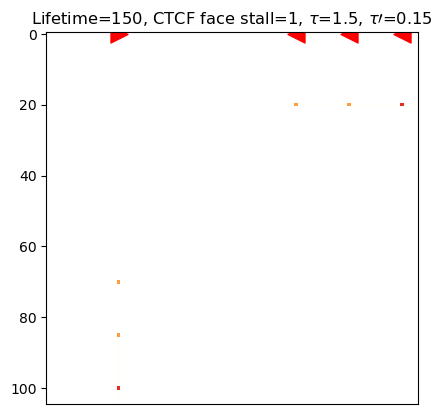

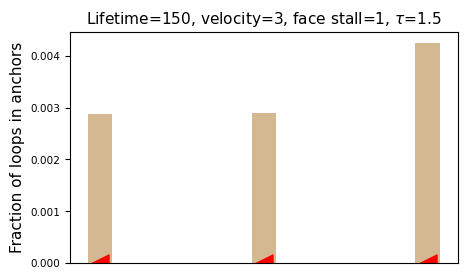

700000


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[ 11  14]
 [ 10  15]
 [  9  16]
 ...
 [ 30 148]
 [ 30 148]
 [ 30 148]]


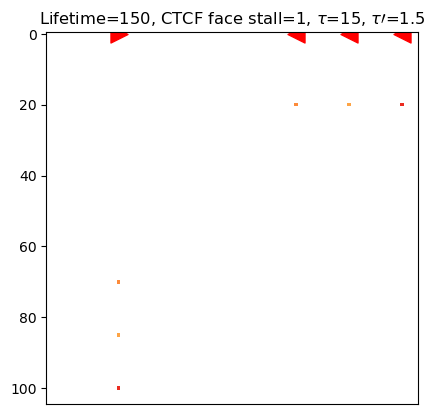

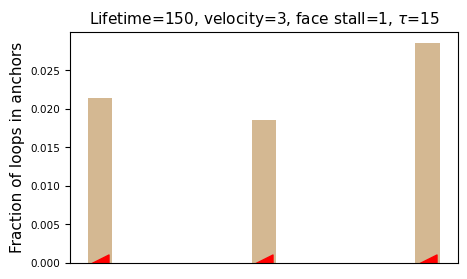

700000


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[48 51]
 [47 52]
 [46 53]
 ...
 [30 80]
 [30 80]
 [30 80]]


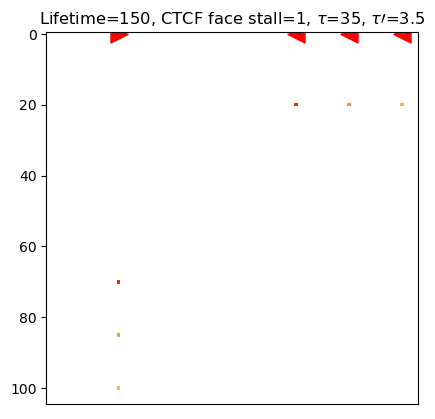

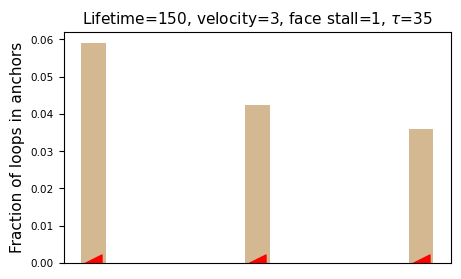

700000


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[109 110]
 [108 110]
 [107 110]
 ...
 [  1 148]
 [  1 148]
 [  1 148]]


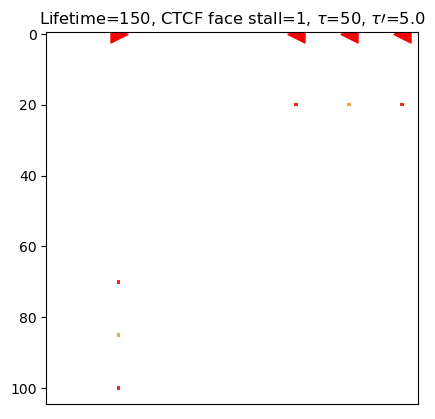

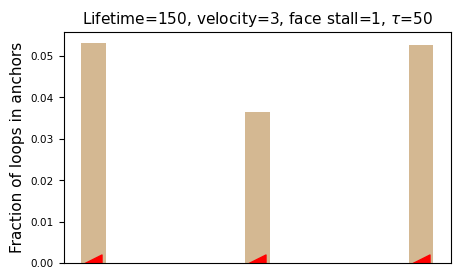

In [62]:
paramdict_CTCF = {
    'CTCF_facestall': [1, 1],
    'CTCF_backstall': [0., 0.],
    'CTCF_lifetime': [1000., 1.],
    'CTCF_offtime': [0.1, 1],
    'LEF_lifetime': [150, 150],
    'LEF_stalled_lifetime': [150, 150],
    'LEF_birth': [0.1, 0.1],
    'LEF_pause': [0, 0],
    'LEF_separation': 10,
    'sites_per_monomer': 10,
    'monomers_per_replica': 15,
    'number_of_replica': 1,
    'steps': 200,
    'velocity_multiplier': 1
}

monomers_per_replica = paramdict_CTCF['monomers_per_replica'] 
sites_per_monomer = paramdict_CTCF['sites_per_monomer']

sites_per_replica = monomers_per_replica*sites_per_monomer
monomer_types = np.zeros(monomers_per_replica, dtype=int)
site_types = np.repeat(monomer_types, sites_per_monomer)
print(len(site_types))

# Let's make some strong and weak CTCF regions
typedict = {'strong_CTCF':1, 'weak_CTCF':0}

site_types[sites_per_replica//2:] = typedict['strong_CTCF']
site_types[:sites_per_replica//2] = typedict['weak_CTCF']

# LEF/CTCF properties in type A monomers may be obtained from the paramdict as follows
LEF_lifetime = paramdict_CTCF['LEF_lifetime']
CTCF_facestall = paramdict_CTCF['CTCF_facestall']
CTCF_offtime = paramdict_CTCF['CTCF_offtime']

print(CTCF_offtime[typedict['strong_CTCF']], CTCF_offtime[typedict['weak_CTCF']])

# Create some CTCF boundary sites
CTCF_left_positions = np.array([30])
CTCF_right_positions = np.array([80, 95, 110])

velocity_range=[1, 3]

lifetime_range = [15, 150]

ctcf_life_range = [ 1, 1.5, 15, 35, 50]

ctcf_oftime_range = [0.15, 1.5, 3.5, 5]
c=1
#plt.figure(figsize=(17,17))
for lifetime_val in lifetime_range:
    for velocity_val in velocity_range:
        for ctcf_life in ctcf_life_range:
        
            paramdict_CTCF['LEF_lifetime']=[lifetime_val, lifetime_val]
            paramdict_CTCF['velocity_multiplier'] = velocity_val
            paramdict_CTCF['LEF_stalled_lifetime']: [lifetime_val, lifetime_val]
            paramdict_CTCF['CTCF_lifetime']=[100, ctcf_life]
            paramdict_CTCF['CTCF_offtime']=[0.1, ctcf_life/10]
            
            translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                             site_types,
                                             CTCF_left_positions,
                                             CTCF_right_positions, 
                                             **paramdict_CTCF)
            
            trajectory_length = 700000
            hist = []
            #plt.subplot(4,4,c)
            c +=1
            
            for _ in range(trajectory_length):
                translocator.step()
                hist.append(translocator.LEFs.copy())
            print(np.shape(np.array(hist))[0])
            
            
            
            kymograph = map_from_lefs(np.asarray(hist), sites_per_replica)
            
            #print(kymograph)
            mrc  = kymograph.astype(float)
            merc = mrc/np.median(np.diag(mrc,2))
            #print(mrc)
            mat = np.log(mrc)
            #print(np.shape(mrc))
            #print(mrc)
            edge = 10
            plt.matshow(mrc[edge:115,edge:115], vmax=1+1.5*np.max(mrc[10:130,10:130]),cmap='fall') 
            plt.scatter(CTCF_left_positions-edge, np.zeros(len(CTCF_left_positions)), marker='>', color='red', s =150)
            plt.scatter(CTCF_right_positions-edge, np.zeros(len(CTCF_right_positions)), marker='<', color='red', s =150)
                        
            plt.title(r'Lifetime=%s, CTCF face stall=%s, $\tau$=%s, $\tau\prime$=%s' % (paramdict_CTCF['LEF_lifetime'][1],paramdict_CTCF['CTCF_facestall'][1],
                                                                                        paramdict_CTCF['CTCF_lifetime'][1],
                                                                                        paramdict_CTCF['CTCF_offtime'][1]
                                                                                       ),
                      fontsize=11.75)
            
            plt.xticks([])
            plt.yticks(fontsize=10)
            
            plt.tight_layout()
            plt.savefig(r'Life=%s_vel=%s_facestall=%s_$\tau$=%s_$\tau\prime$=%s.png'% (paramdict_CTCF['LEF_lifetime'][1],paramdict_CTCF['velocity_multiplier'],
                                                                                                     paramdict_CTCF['CTCF_facestall'][1],paramdict_CTCF['CTCF_lifetime'][1],
                                                                                                     paramdict_CTCF['CTCF_offtime'][1]))
            #plotting barchart
            a=np.reshape(np.array(hist),(trajectory_length,2))
            print(a)
            plt.subplots(figsize=(5,3))
            d=[len(a[(a[:,0]==30)&(a[:,1]==80)])/len(a), len(a[(a[:,0]==30)&(a[:,1]==95)])/len(a),len(a[(a[:,0]==30)&(a[:,1]==110)])/len(a)]
            plt.bar(['',' ','  '],d,width=0.15,color='tan',alpha=0.95)
            #plt.scatter([1,2,3],[0,0,0],marker='<',s=150, color= 'red')
            for i, value in enumerate(d):
                plt.scatter(i,  0.000005, marker='<', s=150, color= 'red')
            plt.title(r'Lifetime=%s, velocity=%s, face stall=%s, $\tau$=%s' % (paramdict_CTCF['LEF_lifetime'][1],paramdict_CTCF['velocity_multiplier'],paramdict_CTCF['CTCF_facestall'][1],
                                                                                                    paramdict_CTCF['CTCF_lifetime'][1],
                                                                                                    
                                                                                                   ),fontsize = 11.05)
            plt.xticks([])
            plt.yticks(fontsize=7.5)
            plt.ylabel('Fraction of loops in anchors',fontsize = 11)
            plt.savefig(r'Life=%s_vel=%s_facestall=%s_$\tau$=%s_$\tau\prime$=%s_barchart.png'% (paramdict_CTCF['LEF_lifetime'][1],paramdict_CTCF['velocity_multiplier'],
                                                                                                                 paramdict_CTCF['CTCF_facestall'][1],paramdict_CTCF['CTCF_lifetime'][1],
                                                                                                                 paramdict_CTCF['CTCF_offtime'][1]),bbox_inches='tight', )          
            plt.show()                       
        

### static barriers

150
1 0.1


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[ 28  31]
 [ 27  32]
 [ 26  33]
 ...
 [  1  45]
 [  1  46]
 [133 136]]


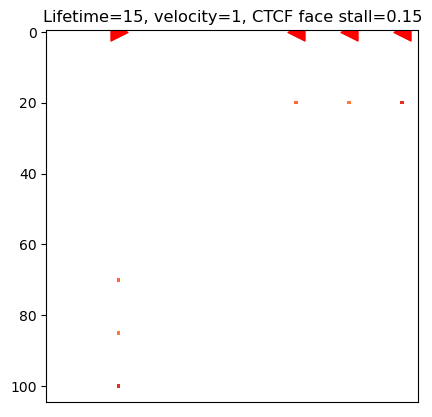

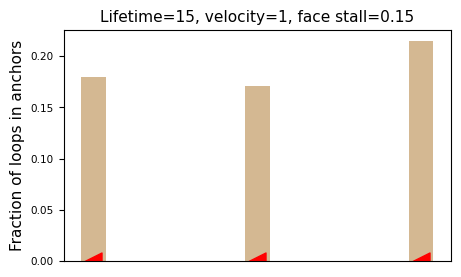

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[83 86]
 [82 87]
 [81 88]
 ...
 [30 80]
 [30 80]
 [30 80]]


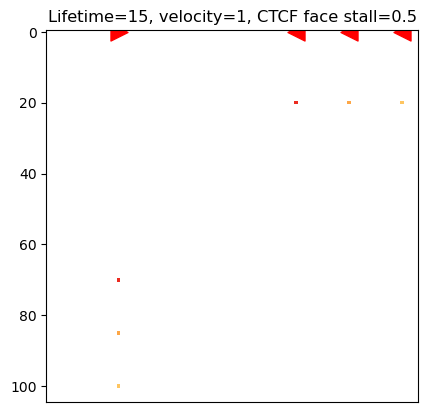

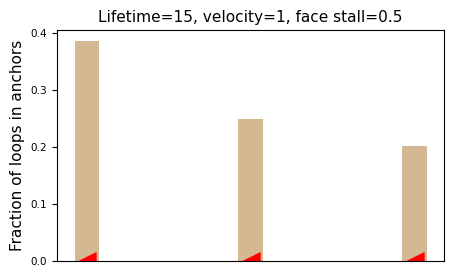

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[ 10  12]
 [  9  13]
 [  8  14]
 ...
 [ 30 110]
 [ 30 110]
 [ 30 110]]


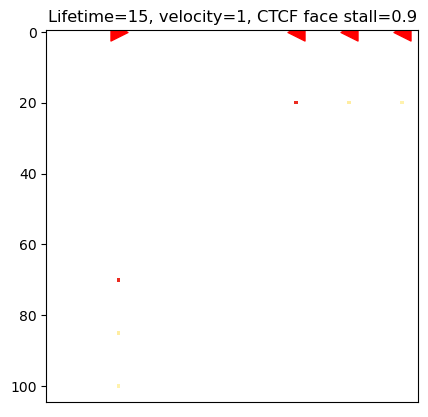

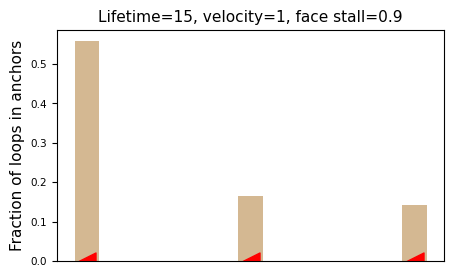

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[110 113]
 [109 114]
 [108 115]
 ...
 [  1 148]
 [  1 148]
 [  1 148]]


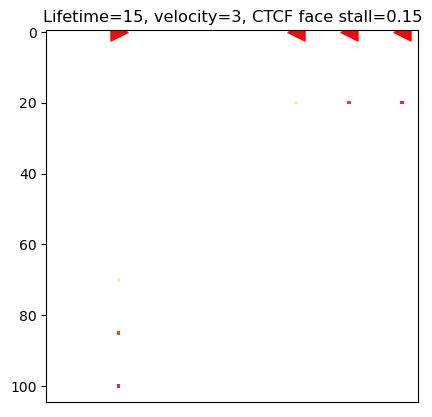

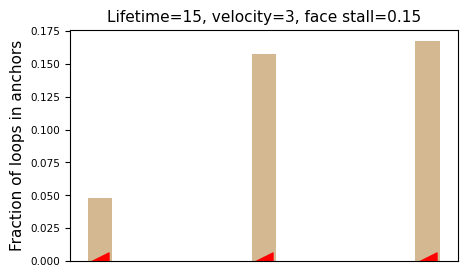

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[ 9 11]
 [ 8 12]
 [ 7 13]
 ...
 [30 80]
 [30 80]
 [30 80]]


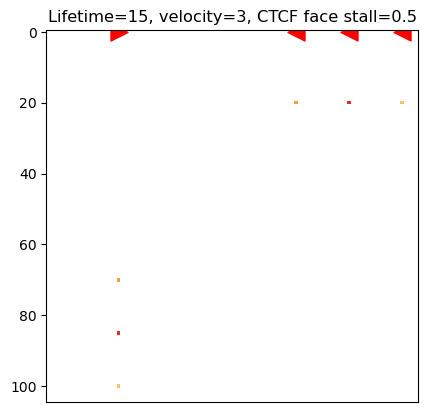

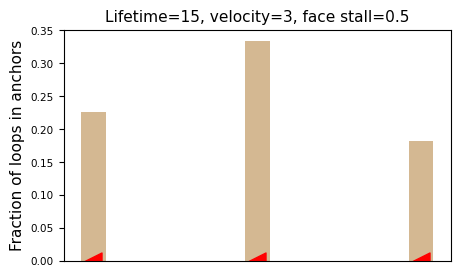

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[ 2  5]
 [ 1  6]
 [ 1  7]
 ...
 [30 80]
 [30 80]
 [30 80]]


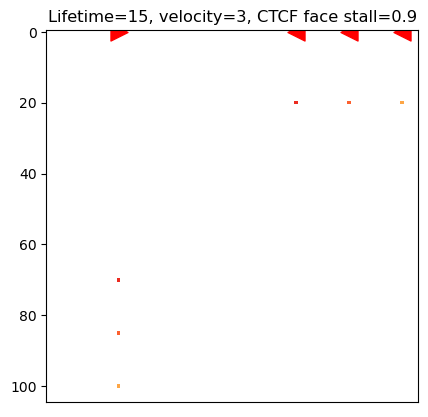

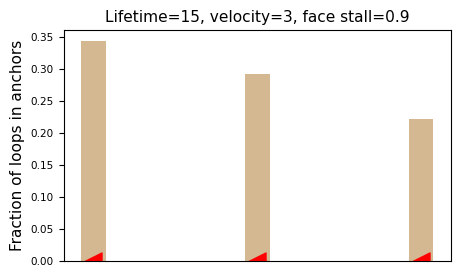

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[ 61  63]
 [ 60  64]
 [ 59  65]
 ...
 [ 30 148]
 [ 30 148]
 [ 30 148]]


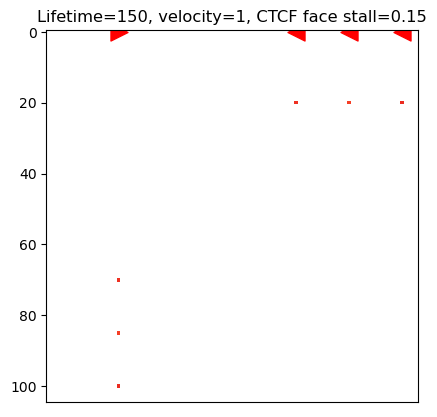

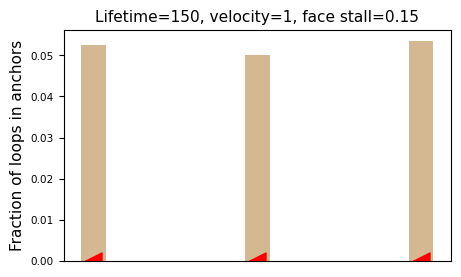

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[80 82]
 [79 83]
 [78 84]
 ...
 [ 1 80]
 [ 1 80]
 [ 1 80]]


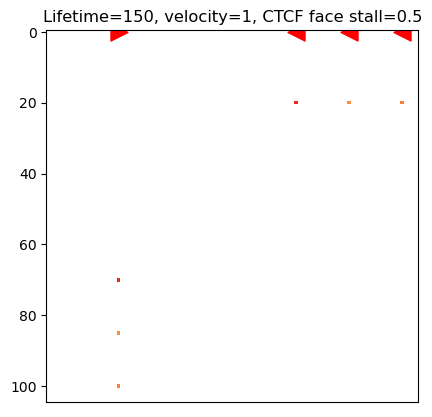

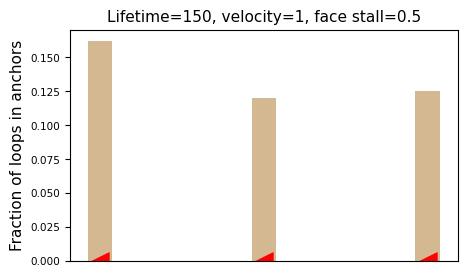

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[65 68]
 [64 69]
 [63 70]
 ...
 [30 95]
 [30 95]
 [30 95]]


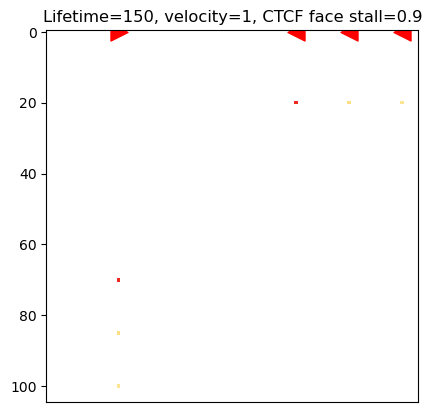

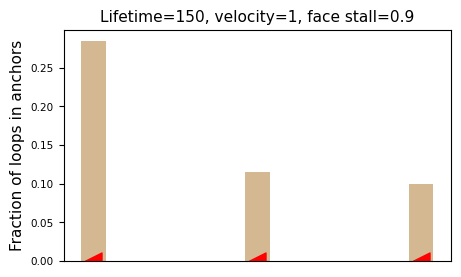

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in true_divide
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[46 48]
 [45 49]
 [44 50]
 ...
 [30 80]
 [30 80]
 [30 80]]


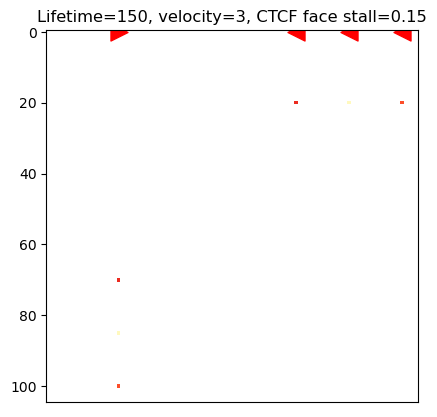

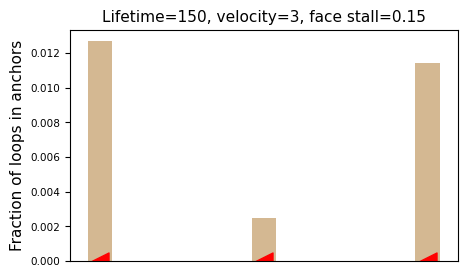

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in true_divide
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[144 146]
 [143 147]
 [142 148]
 ...
 [ 30 110]
 [ 30 110]
 [ 30 110]]


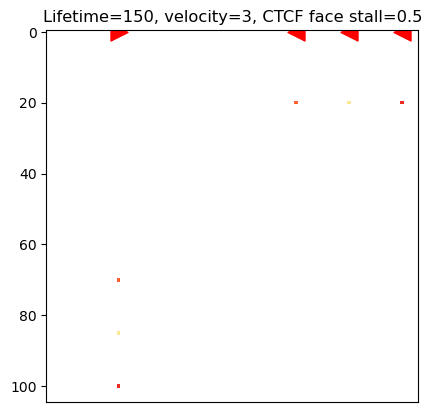

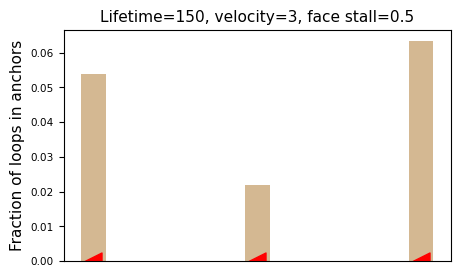

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in true_divide
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[[  3   5]
 [  2   6]
 [  1   7]
 ...
 [ 30 148]
 [ 30 148]
 [ 30 148]]


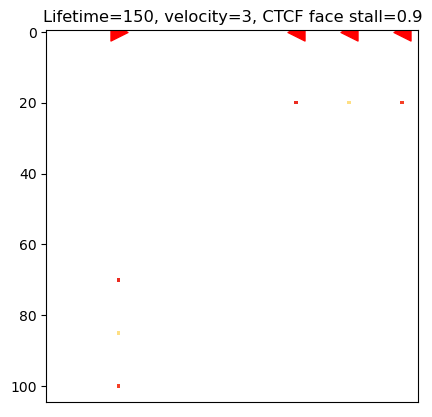

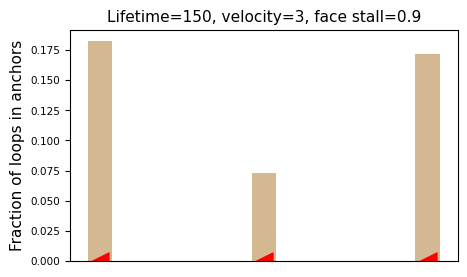

In [61]:
paramdict_CTCF = {
    'CTCF_facestall': [1, 1],
    'CTCF_backstall': [0., 0.],
    'CTCF_lifetime': [1000., 1.],
    'CTCF_offtime': [0.1, 1],
    'LEF_lifetime': [150, 150],
    'LEF_stalled_lifetime': [150, 150],
    'LEF_birth': [0.1, 0.1],
    'LEF_pause': [0, 0],
    'LEF_separation': 10,
    'sites_per_monomer': 10,
    'monomers_per_replica': 15,
    'number_of_replica': 1,
    'steps': 200,
    'velocity_multiplier': 1
}

monomers_per_replica = paramdict_CTCF['monomers_per_replica'] 
sites_per_monomer = paramdict_CTCF['sites_per_monomer']

sites_per_replica = monomers_per_replica*sites_per_monomer
monomer_types = np.zeros(monomers_per_replica, dtype=int)
site_types = np.repeat(monomer_types, sites_per_monomer)
print(len(site_types))

# Let's make some strong and weak CTCF regions
typedict = {'strong_CTCF':1, 'weak_CTCF':0}

site_types[sites_per_replica//2:] = typedict['strong_CTCF']
site_types[:sites_per_replica//2] = typedict['weak_CTCF']

# LEF/CTCF properties in type A monomers may be obtained from the paramdict as follows
LEF_lifetime = paramdict_CTCF['LEF_lifetime']
CTCF_facestall = paramdict_CTCF['CTCF_facestall']
CTCF_offtime = paramdict_CTCF['CTCF_offtime']

print(CTCF_offtime[typedict['strong_CTCF']], CTCF_offtime[typedict['weak_CTCF']])

# Create some CTCF boundary sites
CTCF_left_positions = np.array([30])
CTCF_right_positions = np.array([80, 95, 110])

velocity_range=[1, 3]
face_prob_range = [0.15, 0.5, 0.9]
lifetime_range = [15, 150]

ctcf_life_range = [ 1, 1.5,15, 35, 50]

ctcf_oftime_range = [0.15,1.5, 3.5, 5]
c=1
#plt.figure(figsize=(17,17))
for lifetime_val in lifetime_range:
    for velocity_val in velocity_range:
        for face_prob in face_prob_range:   
            paramdict_CTCF['LEF_lifetime']=[lifetime_val, lifetime_val]
            paramdict_CTCF['velocity_multiplier'] = velocity_val
            paramdict_CTCF['CTCF_facestall']=[1,face_prob]
            paramdict_CTCF['LEF_stalled_lifetime']: [lifetime_val, lifetime_val]
            paramdict_CTCF['CTCF_lifetime']=[100, ctcf_life]
            paramdict_CTCF['CTCF_offtime']=[0.1, ctcf_life/10]
            
            translocator = make_translocator(LEFTranslocator, 
                                             site_types,
                                             CTCF_left_positions,
                                             CTCF_right_positions, 
                                             **paramdict_CTCF)
            
            trajectory_length = 700000
            hist = []
            c +=1
            
            for _ in range(trajectory_length):
                translocator.step()
                hist.append(translocator.LEFs.copy())
            
            
            kymograph = map_from_lefs(np.asarray(hist), sites_per_replica)
            
            mrc  = kymograph.astype(float)
            merc = mrc/np.median(np.diag(mrc,2))
            mat = np.log(mrc)
            edge = 10
            plt.matshow(mrc[edge:115,edge:115], vmax=1+1.5*np.max(mrc[10:130,10:130]),cmap='fall') 
            plt.scatter(CTCF_left_positions-edge, np.zeros(len(CTCF_left_positions)), marker='>', color='red', s =150)
            plt.scatter(CTCF_right_positions-edge, np.zeros(len(CTCF_right_positions)), marker='<', color='red', s =150)
                        
            plt.title(r'Lifetime=%s, velocity=%s, CTCF face stall=%s' % (paramdict_CTCF['LEF_lifetime'][1],paramdict_CTCF['velocity_multiplier'],paramdict_CTCF['CTCF_facestall'][1],
                                                                                       ),
                      fontsize=11.75)
            
            plt.xticks([])
            plt.yticks(fontsize=10)
            
            plt.tight_layout()
            plt.savefig('Static_Life=%s_vel=%s_facestall=%s.png'% (paramdict_CTCF['LEF_lifetime'][1],paramdict_CTCF['velocity_multiplier'],paramdict_CTCF['CTCF_facestall'][1]))
                      
            #plotting barchart
            a=np.reshape(np.array(hist),(trajectory_length,2))
            print(a)
            plt.subplots(figsize=(5,3))
            d=[len(a[(a[:,0]==30)&(a[:,1]==80)])/len(a), len(a[(a[:,0]==30)&(a[:,1]==95)])/len(a),len(a[(a[:,0]==30)&(a[:,1]==110)])/len(a)]
            plt.bar(['',' ','  '],d,width=0.15,color='tan',alpha=0.95)
            #plt.scatter([1,2,3],[0,0,0],marker='<',s=150, color= 'red')
            for i, value in enumerate(d):
                plt.scatter(i,  0.000005, marker='<', s=150, color= 'red')
            plt.title(r'Lifetime=%s, velocity=%s, face stall=%s' % (paramdict_CTCF['LEF_lifetime'][1],paramdict_CTCF['velocity_multiplier'],paramdict_CTCF['CTCF_facestall'][1],
                                                                                                    
                                                                                                   ),fontsize = 11.05)
            plt.xticks([])
            plt.yticks(fontsize=7.5)
            plt.ylabel('Fraction of loops in anchors',fontsize = 11)
            plt.savefig(r'Static_Life=%s_vel=%s_facestall=%s_$\tau$=%s_$\tau\prime$=%s_barchart.png'% (paramdict_CTCF['LEF_lifetime'][1],paramdict_CTCF['velocity_multiplier'],
                                                                                                                 paramdict_CTCF['CTCF_facestall'][1],paramdict_CTCF['CTCF_lifetime'][1],
                                                                                                                 paramdict_CTCF['CTCF_offtime'][1]))          
            plt.show()                                 
    